In [1]:
import sys
sys.path.append('/home/johnny/haveibeentrainedon2/src')

import load_data
import watermark
import features
import utils
import defense

In [2]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
ds = load_data.load_subset(rows=1000)

/home/johnny/.conda/envs/torch/lib/python3.8/site-packages/datasets/load.py:1486: FutureWarning: The repository for wikipedia contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/wikipedia
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [4]:
prefix = 'natural_ct'

if prefix == 'rand_seq':
    wm_ds = watermark.random_sequence_watermark(ds)
    examples = utils.create_examples(wm_ds, col_name='rand_seq:text')
elif prefix == 'natural_ct':
    wm_ds = watermark.natural_copyright_trap_watermark(ds, n=20)
    examples = utils.create_examples(wm_ds, col_name='natural_ct:text')

Token indices sequence length is longer than the specified maximum sequence length for this model (3814 > 1024). Running this sequence through the model will result in indexing errors


In [5]:
len(examples)

1000

In [6]:
vectorizer, scores = defense.naive_exact_match(examples,n=8)

2024-06-20 18:04:49.679555: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [7]:
labels = np.array(wm_ds[f'{prefix}:label'])
scores = np.array(scores)

Text(0.5, 1.0, 'roc auc: 0.662')

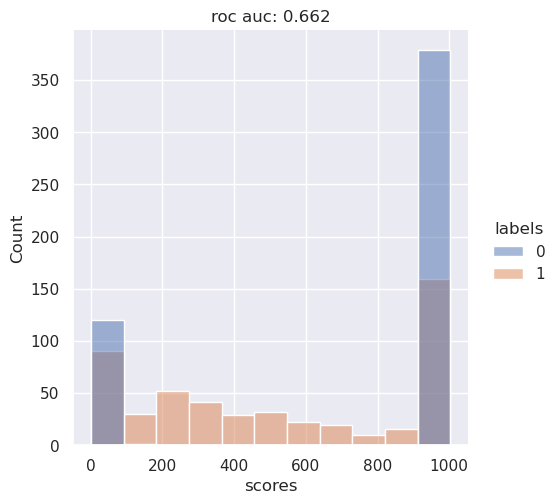

In [8]:
df = pd.DataFrame({'scores' : np.array(scores) + np.random.randint(1, 5, size=len(scores)), 'labels' : labels})
sns.displot(data=df, x='scores', hue='labels')

rocauc = roc_auc_score(1-labels, scores)
plt.title('roc auc: %.3f' % rocauc)

In [9]:
fpr, tpr, threshold = sklearn.metrics.roc_curve(1-labels, scores)

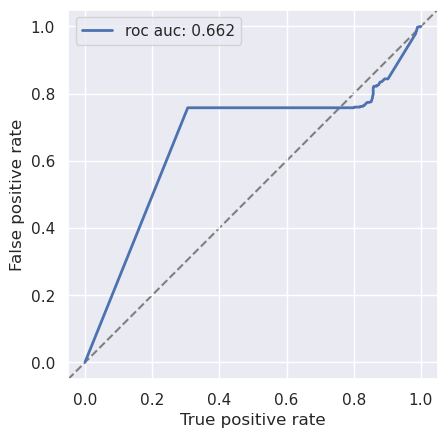

In [10]:
# Plot the TP vs. FP curve
plt.figure()
ax = plt.gca()
plt.plot(fpr, tpr, lw=2, label='roc auc: %.3f' % rocauc)
plt.xlabel('True positive rate')
plt.ylabel('False positive rate')

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, linestyle='--', color='gray', zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.legend()
plt.grid(True)
plt.show()